In [1]:
%%capture
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import calc_class_weights
from pyecg.data_info import *
from pyecg.data_handling import DataHandling
from pyecg.report import Reports
from pyecg.data_preprocessing import clean_inf_nan,clean_IQR
from pyecg.utils import sig_similarity_report,sig_similarity_hist
from pyecg.data_handling import slice_data
from pyecg.data_rpeak import *


reset_seed() 

2022-06-24 11:20:41.400621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 11:20:41.400660: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-24 11:20:54.152663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-24 11:20:54.152699: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 11:20:54.152729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-06-24 11:20:54.153034: I tensorflow/core/platform/cpu_feature_gua

# Proto

In [2]:
datasets = {1:'raw_rpeak'}
models = {1:'rpeak1'}

CONFIG = {}
CONFIG['dataset'] = datasets[1]
CONFIG['model'] = models[1]
CONFIG['model_type'] = 'CLF' #CLF or AE
CONFIG['augment'] = False 
CONFIG['sliced_targets'] = None #{'N':0} #None  #{'N':0,'A':1}
CONFIG['AAMI'] = False 
CONFIG['class_weight'] = False 
CONFIG['normalization'] = None      #'zscore' 'minmax' , None, 'max' 

# Data

In [3]:
#Load data 
if CONFIG['dataset'] == 'raw_rpeak': 
    annotated_records, samples_info = load_data(file_path = '../data/DS1_samples.rpeak')

File loaded: ../data/DS1_samples.rpeak


In [4]:
samples_info[0][2]-samples_info[0][1]  #win size 

10800

In [5]:
labels=[]
for sample in samples_info:
    labels.append(sample[3])
len(labels)
np.unique(labels,return_counts=True)

(array([0, 1]), array([4355824, 1504976]))

In [6]:
labels=[]
for sample in samples_info:
    labels.append(sample[3])
len(labels)

39072

In [7]:
class_labels,counts = list(np.unique(labels,return_counts=True))
class_labels,counts

(array([0, 1]), array([4355824, 1504976]))

In [8]:
len(annotated_records[0][0]) #signal length

650000

In [9]:
np.unique(labels,return_counts=True)

(array([0, 1]), array([4355824, 1504976]))

# Train

In [10]:
if CONFIG['model'] == 'rpeak1':
    from pyecg.models.rpeak1 import model_arch 

In [11]:
params_model = {
    'x_input_dim' : samples_info[0][2]-samples_info[0][1],  #win size
    'out_seq_len' : len(labels[0]),
    'num_classes' : len(np.unique(labels)),
    'regularizer' : None
}
params_train = {
    'batch_size' : 128,
    'epochs' : 1
} 

In [12]:
params_model

{'x_input_dim': 10800,
 'out_seq_len': 150,
 'num_classes': 2,
 'regularizer': None}

In [13]:
mymodel = model_arch(params_model)                                          


Layer: X_INPUT_DIM -->  Output shape: [None, 150, 14]

Layer: DROPOUT/IDENTITY:0 -->  Output shape: [None, 150, 128]

Layer: DROPOUT_1/IDENTITY:0 -->  Output shape: [None, 150, 128]

Layer: DENSE_1/SOFTMAX:0 -->  Output shape: [None, 150, 2]


In [14]:
mymodel.summary()

Model: "Model_Conv1d_Rpeak"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_input_dim (InputLayer)    [(None, 150, 14)]         0         
                                                                 
 batch_normalization (BatchN  (None, 150, 14)          56        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 150, 128)         40448     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 150, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                

In [15]:
#%%capture
#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss

In [16]:
def my_log_loss(y_true, y_pred):
    squared_difference = tf.square(tf.math.log(y_true + 5) - tf.math.log(y_pred + 5))
    return tf.reduce_mean(squared_difference, axis=-1) 

In [17]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

def get_loss(model_type):
    if model_type == 'AE':
        loss = "mse"
        #loss = 'binary_crossentropy'
        #loss='mean_squared_logarithmic_error'
        #loss = my_log_loss
        #loss = 'cosine_similarity'
    else:
        #loss = "binary_crossentropy"
        loss = "sparse_categorical_crossentropy"
        #loss=SparseCategoricalFocalLoss(gamma=3)
    return loss

def get_metrics(model_type):
    if model_type == 'AE':
        metrics = None
    else:
        metrics = ['accuracy']
    return metrics
    

mymodel.compile(
              optimizer = opt,
              loss = get_loss(CONFIG['model_type']),
              metrics = get_metrics(CONFIG['model_type']),
              loss_weights = None
              )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)
import time
batch_sleep = tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch,logs: time.sleep(.0001))

callbacks = [early_stopping, model_checkpoint, reduce_lr, batch_sleep]  
callbacks = [batch_sleep]  

rm: cannot remove '/media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1': No such file or directory


In [18]:
class_labels

array([0, 1])

In [19]:
bnry_ = True
cl_ = list(class_labels) #None
train_generator = ECGSequence(annotated_records,
                              samples_info,
                              batch_size=params_train['batch_size'],
                              binary=bnry_,
                              raw=False
                              #class_labels=cl_)
                             )

In [20]:
%%time
#%%prun -s cumulative

#model fitting
model_history = mymodel.fit_generator(generator=train_generator,
                                    #validation_data=validation_generator,
                                    use_multiprocessing=True,
                                    #workers=2,
                                    epochs=params_train['epochs'],
                                    verbose=1,
                                    callbacks=callbacks
                                     )


<timed exec>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


306/306 [==============================] - 319s 1s/step - loss: 0.0380 - accuracy: 0.9836
CPU times: user 14min 20s, sys: 50.3 s, total: 15min 11s
Wall time: 5min 19s


In [21]:
#train_generator.__getitem__(0)[0]

In [22]:
#mymodel.predict(train_generator.__getitem__(0)[0])

In [23]:
#plot_loss(model_history) 

import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)

a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

# Loading Model

In [24]:
#loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
#mymodel = tf.keras.models.load_model(BASEPATH+'saved_models/mymodel')
loaded_model = mymodel
loaded_model.name 
#loaded_model.summary() 

'Model_Conv1d_Rpeak'

In [25]:
#Load Test Set
#Load data
if CONFIG['dataset'] == 'raw_rpeak': 
    annotated_records_test, samples_info_test = load_data(file_path = '../data/DS2_samples.rpeak')

File loaded: ../data/DS2_samples.rpeak


In [26]:
len(samples_info_test)

1320

In [27]:
labels=[]
for sample in samples_info_test:
    labels.append(sample[3])
len(labels)

np.unique(labels,return_counts=True)

(array([0, 1]), array([148445,  49555]))

In [28]:
#Test generator
batch_size=128
test_generator = ECGSequence(annotated_records_test,
                              samples_info_test,
                              batch_size=batch_size,
                              binary=bnry_,
                              raw=False
                              #class_labels=cl_)
                            )

In [29]:
labels_true=[]
labels_pred = []
for i in range(round(len(samples_info_test)/batch_size)): 
    samples = test_generator.__getitem__(i)
    
    labels_true.extend(samples[1])
    probs = loaded_model.predict_generator(samples[0])
    labels_pred.extend(list(np.argmax(probs,axis=-1)))

labels_true = np.array(labels_true)
labels_pred = np.array(labels_pred)
assert labels_true.shape == labels_pred.shape

/tmp/ipykernel_6637/3851531521.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probs = loaded_model.predict_generator(samples[0])


In [30]:
if cl_:
    labels_true = np.array([class_labels[i] for i in labels_true])
    labels_pred = np.array([class_labels[i] for i in labels_pred])

In [31]:
min(probs.flatten()), max(probs.flatten())

(1.3934185e-08, 0.99999994)

In [32]:
labels_true.shape

(1280, 150)

In [33]:
np.unique(labels_pred),np.unique(labels_true) 

(array([0, 1]), array([0, 1]))

In [34]:
if CONFIG['model_type'] == 'CLF':
    from sklearn.metrics import confusion_matrix, classification_report
    true = labels_true.flatten() 
    pre = labels_pred.flatten() 
    print(classification_report(true, pre))
    print(confusion_matrix(true, pre)) 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    143908
           1       0.98      0.99      0.98     48092

    accuracy                           0.99    192000
   macro avg       0.99      0.99      0.99    192000
weighted avg       0.99      0.99      0.99    192000

[[142992    916]
 [   559  47533]]


# misclassified

/tmp/ipykernel_6637/3660683550.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probs = loaded_model.predict_generator(samples[0])


141
[[0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0
  1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0
  1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0
  0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0
  0 1 0 0 1 0]]
[[0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0
  1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0
  1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0
  0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0
  0 1 0 0 1 0]]
142
[[0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
  0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1
  0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0
  1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
  0 1 0 1 0 0]]
[[0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 

179
[[0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0
  1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0
  1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1
  0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0
  1 0 0 1 0 0]]
[[1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0
  1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0
  1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1
  0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0
  1 0 0 1 0 0]]


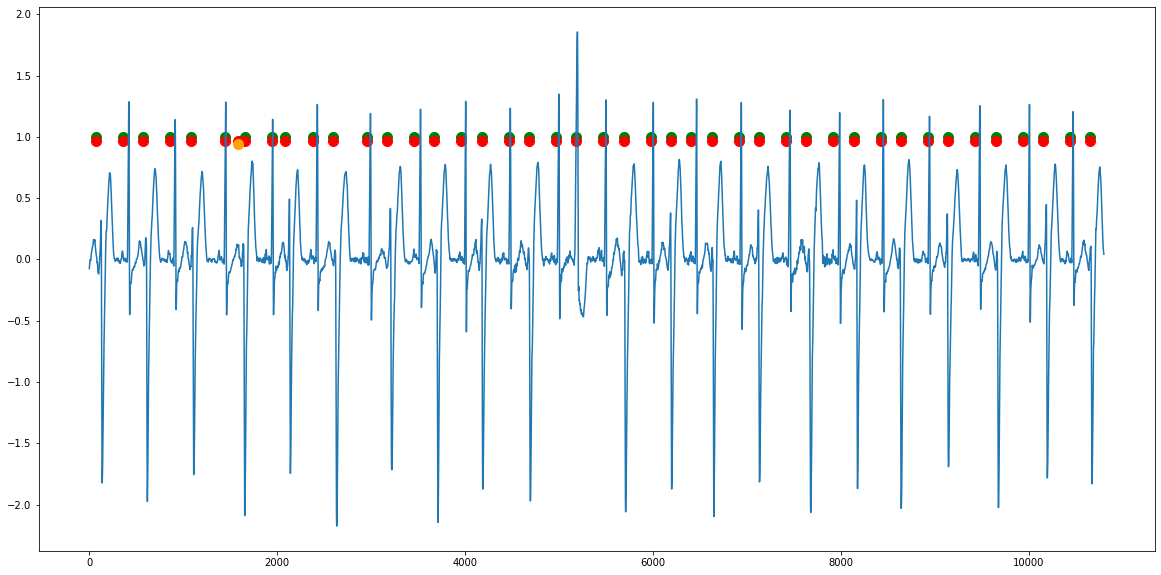

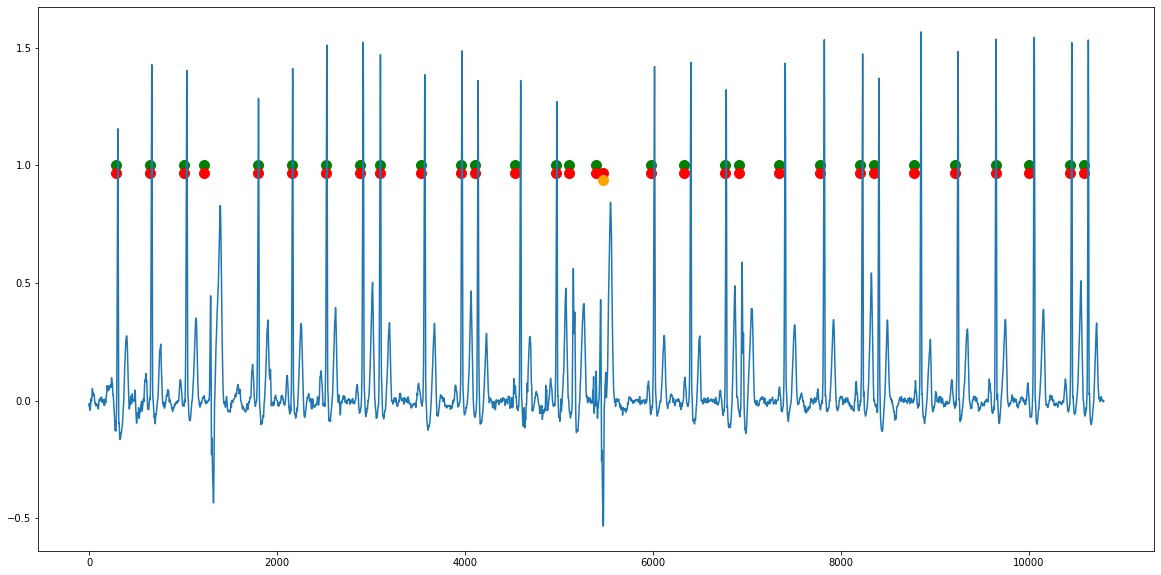

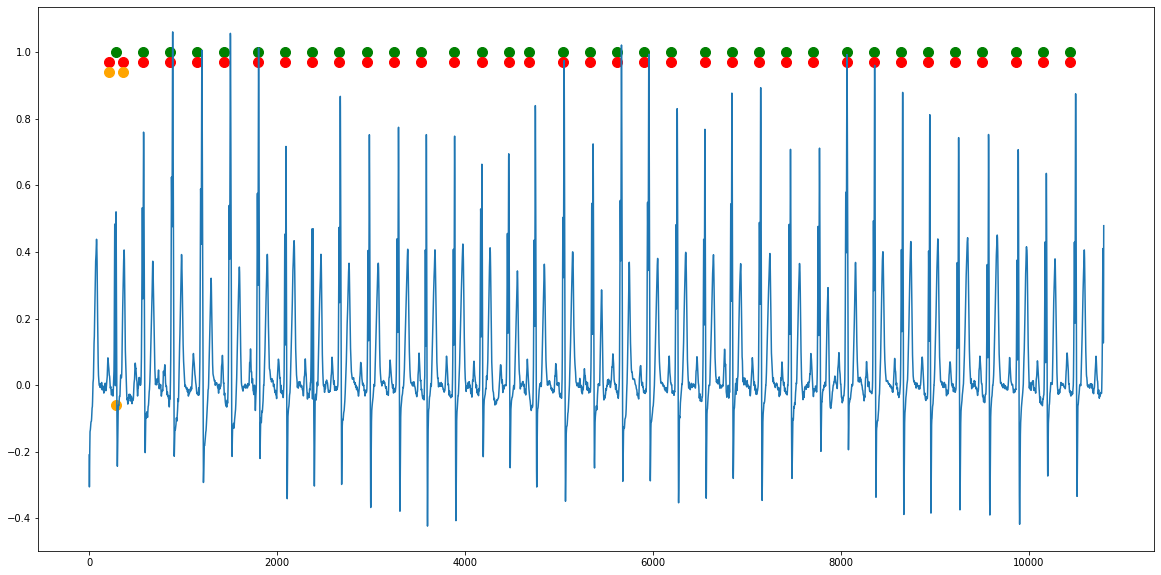

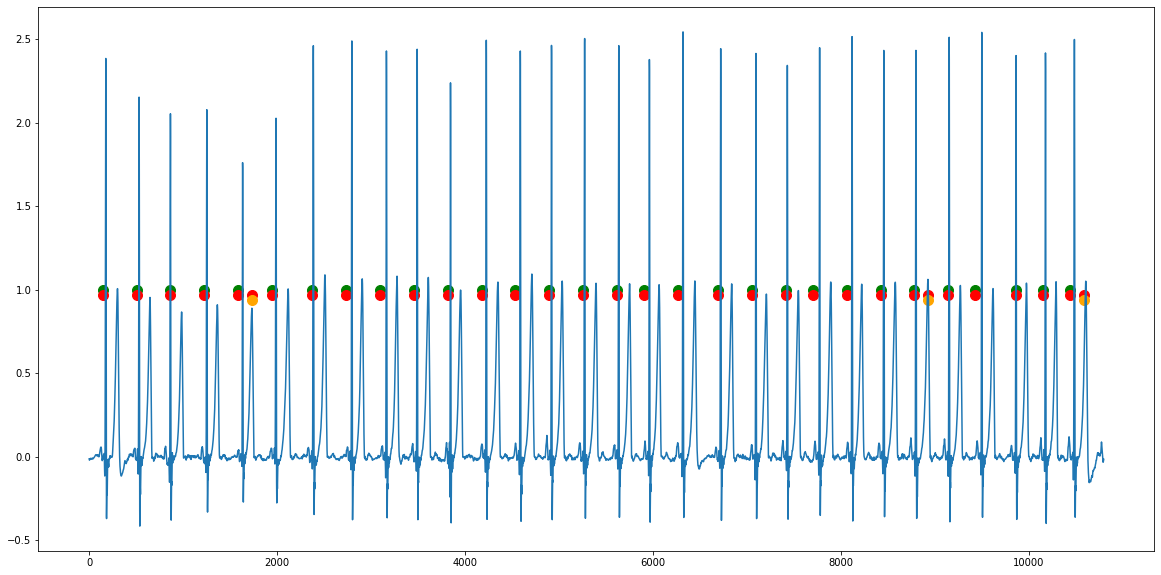

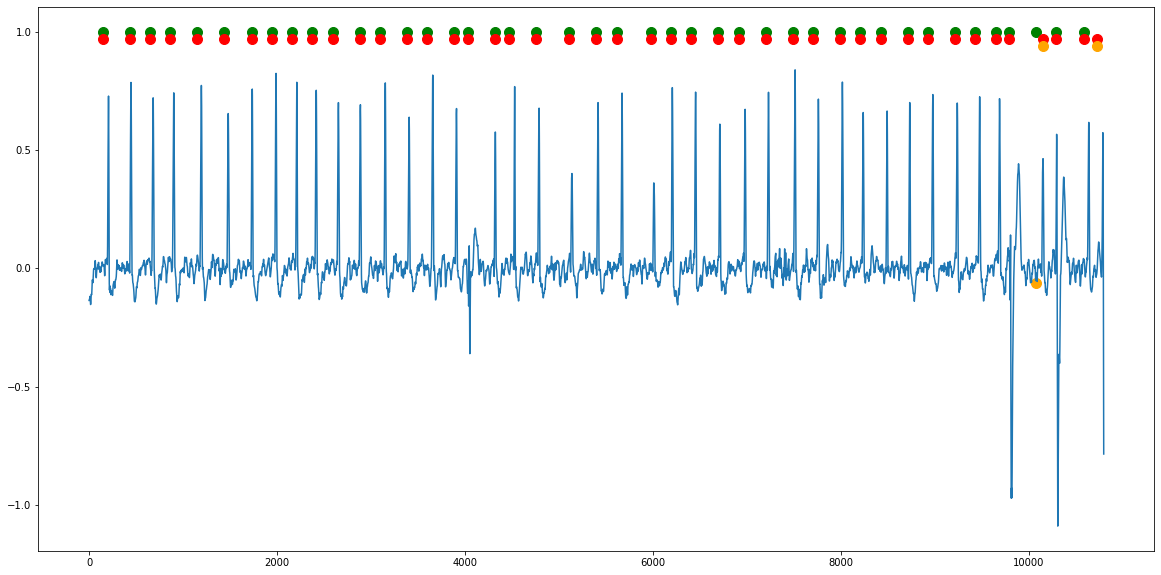

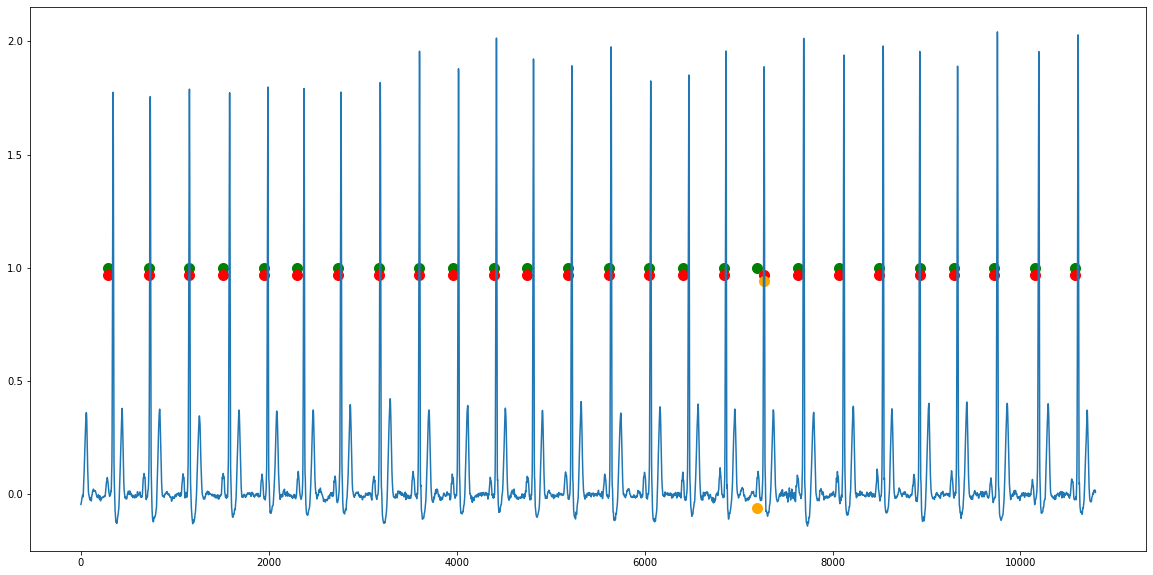

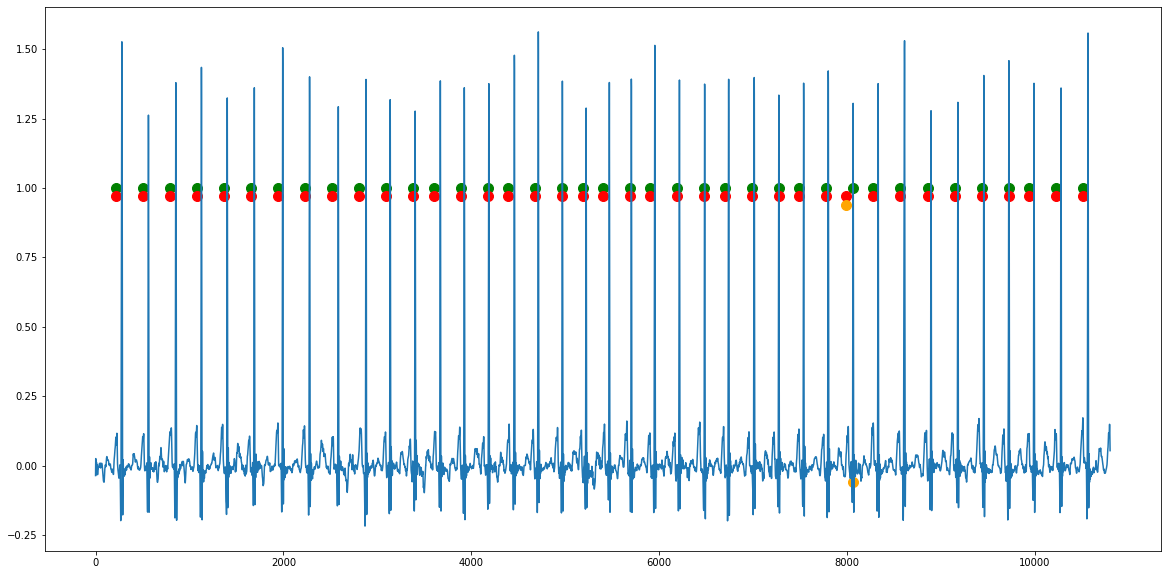

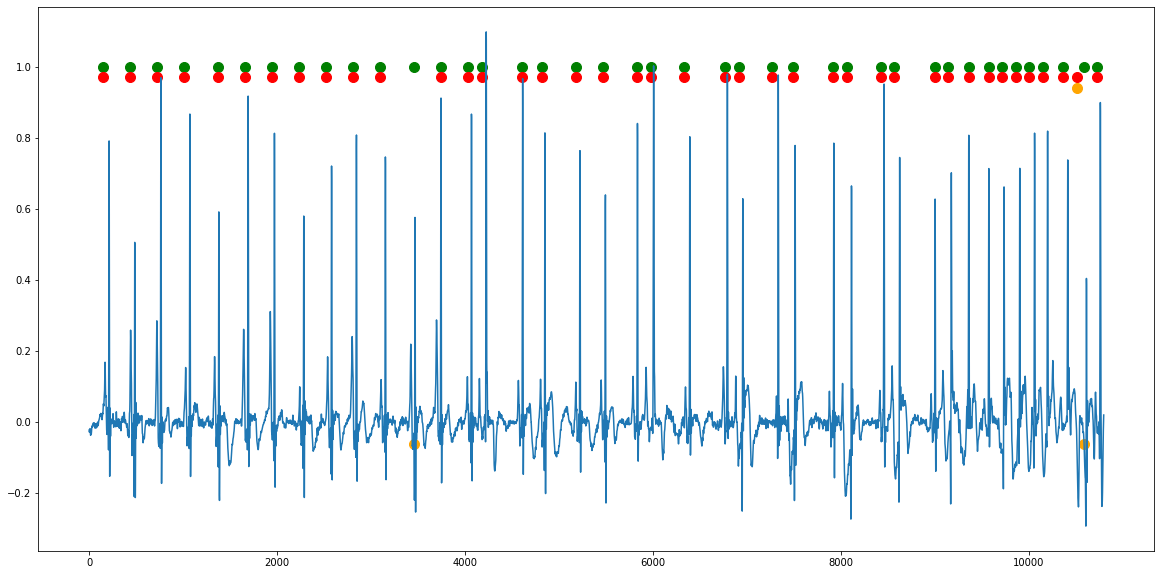

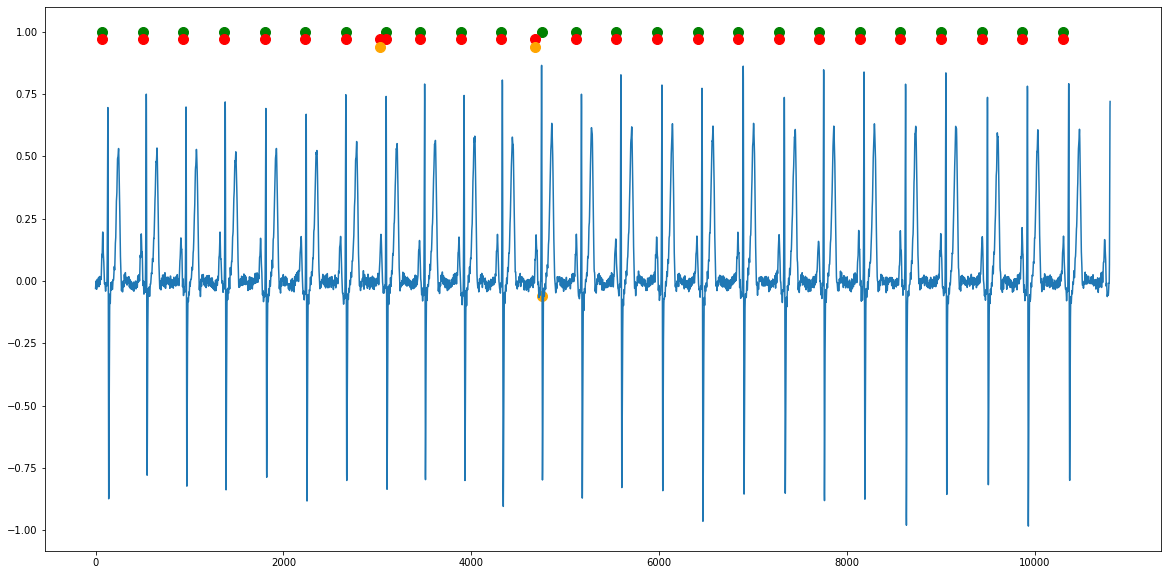

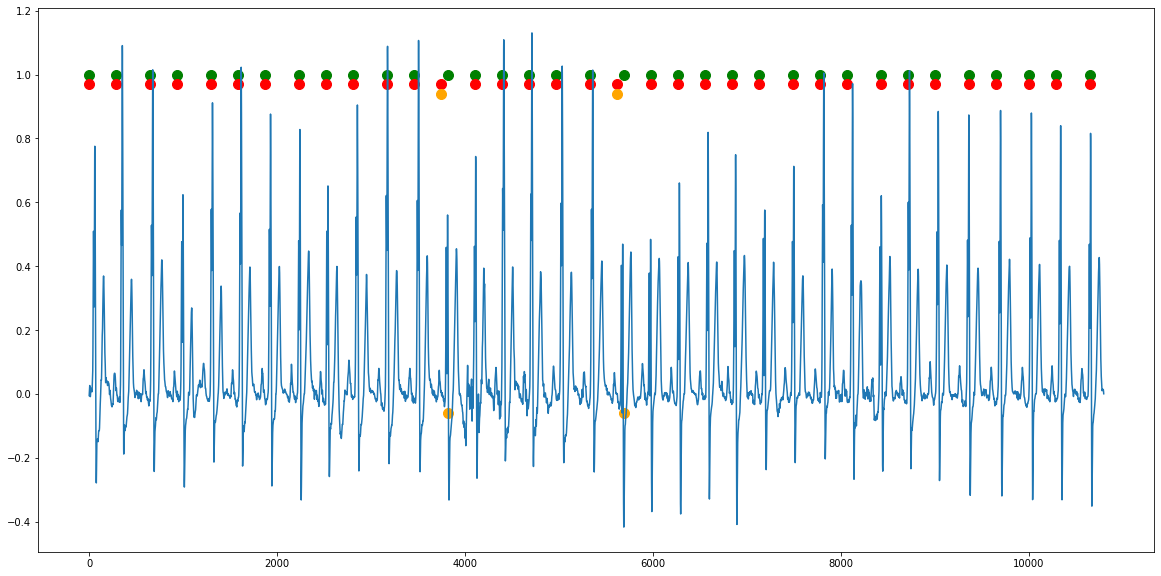

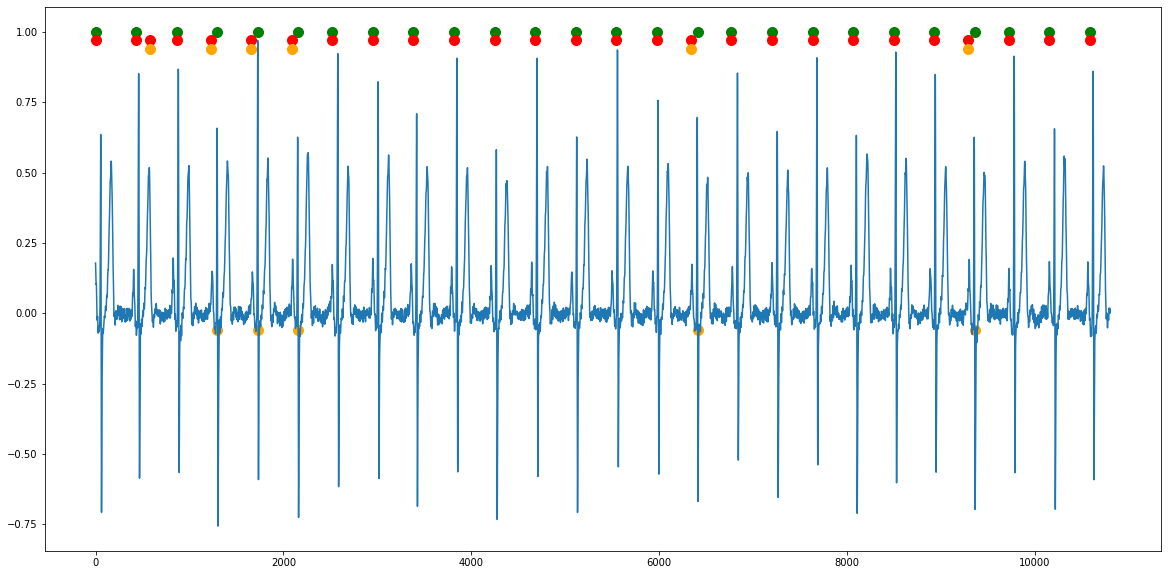

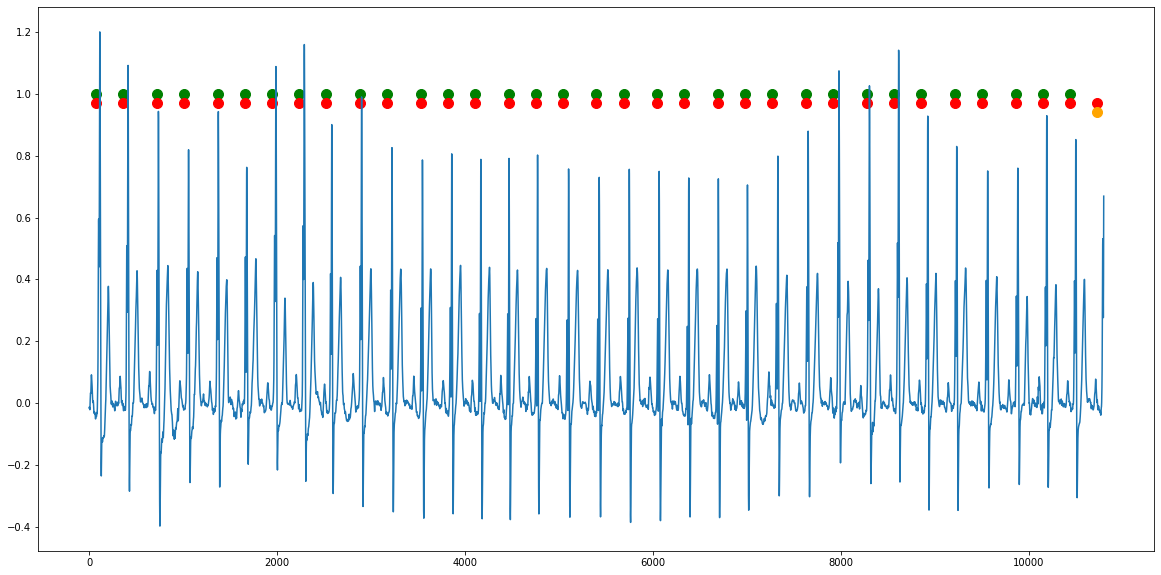

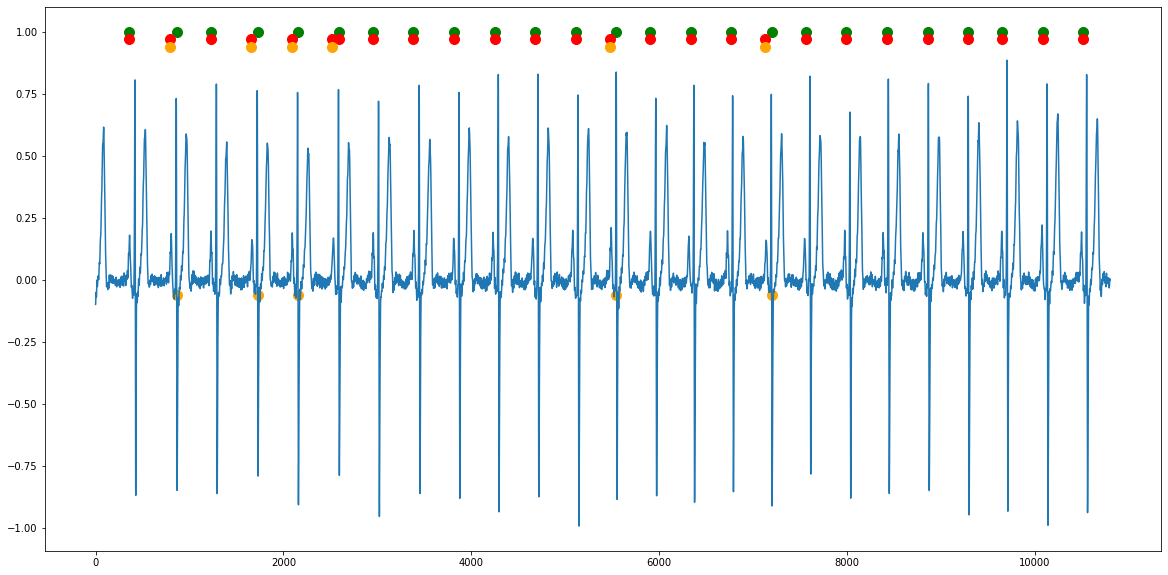

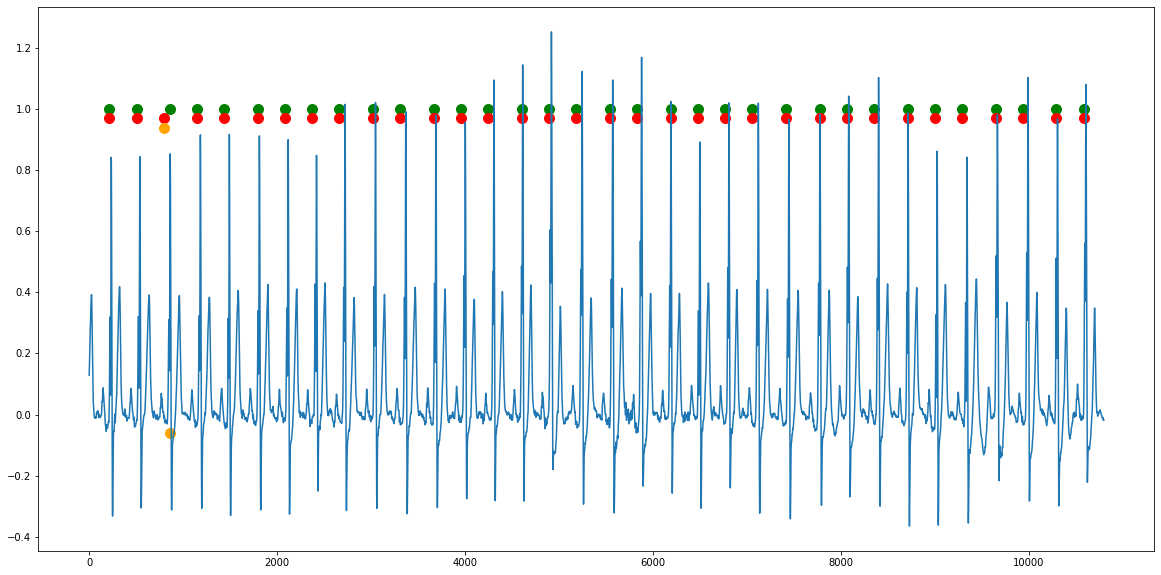

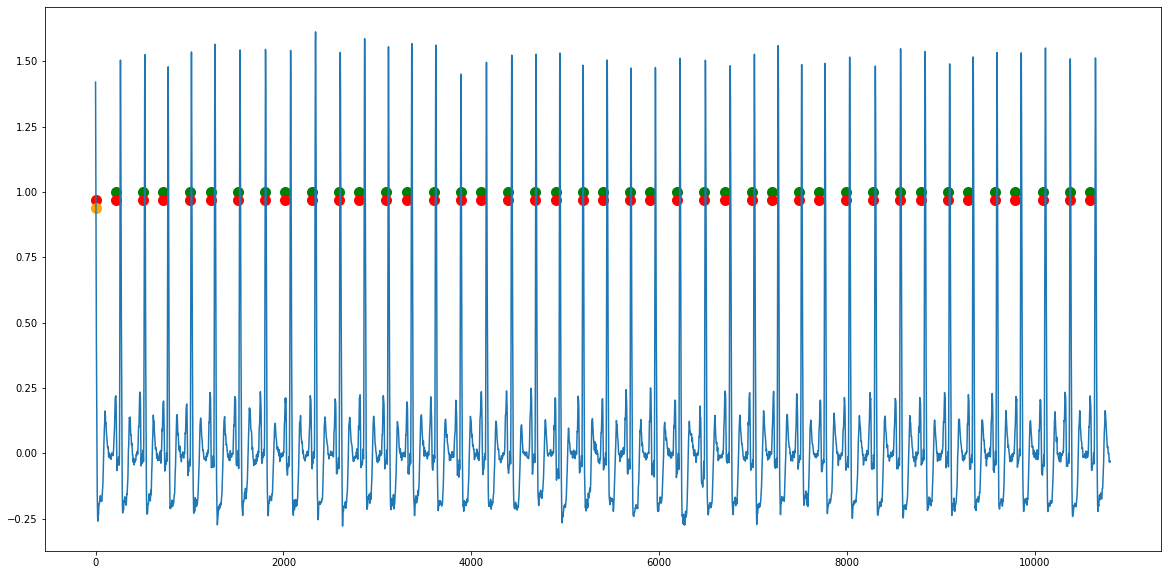

In [35]:
#Test generator
batch_size=1


labels_true=[]
labels_pred = []
for i in range(140,180):   #range(round(len(samples_info_test)/batch_size)): 
    test_generator = ECGSequence(annotated_records_test,
                                  [samples_info_test[i]],
                                  batch_size=batch_size,
                                  binary=bnry_
                                  #class_labels=cl_)
                                )
    samples = test_generator.__getitem__(0)
    
    labels_true=samples[1]
    probs = loaded_model.predict_generator(samples[0])
    labels_pred = np.argmax(probs,axis=-1)

    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    if not np.array_equal(labels_true,labels_pred):
        print(i)
        print(labels_true)
        print(labels_pred)
        rec = samples_info_test[i][0]
        st = samples_info_test[i][1]
        en = samples_info_test[i][2]
        
        sig = annotated_records_test[rec][0][st:en]
        plt.figure(figsize=(20,10))
        plt.plot(sig)
        for p in range(labels_true.shape[1]):
            if labels_true[0][p]==1:
                plt.scatter(p*72,labels_true[0][p],s=100,c='g')
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p]==1:
                plt.scatter(p*72,labels_pred[0][p]-.03,s=100,c='r')
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p]!=labels_true[0][p]:
                plt.scatter(p*72,labels_pred[0][p]-.06,s=100,c='orange')
        